In [74]:
import csv
from collections import defaultdict
from itertools import combinations
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn
import pandas as pd

In [61]:
# load data

class Child():
    def __init__(self, data):
        self.id = data[1]
        self.family = data[0]
        self.relatedness = data[2]
        self.sex = data[5]
        self.age = None if data[6]=='' or int(data[6])<0 or int(data[6])>100 else int(data[6])
        self.diagnoses = set(data[7].split(','))
        self.asd = data[8]
        self.premature = data[9]
        self.gestation = 40 if data[10]=='' else int(data[10])
        self.verbal = int(data[11])
        self.sleep = data[12]
        self.hearing = data[13]
        self.vision = data[14]
        self.noise = data[15]
        self.motor = data[16]
        self.metabolic = data[17]
        self.gi = data[18]
        self.infections = data[19]
        self.seizures = data[20]
        
    def __str__(self):
        return 'Child(id=%s, fam=%s)' % (self.id, self.family)

fam_to_children = defaultdict(list)
children = []
with open('../data/kfPedsFileExport_09-12-2022.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    for line in reader:
        child = Child(line)
        fam_to_children[child.family].append(child)
        children.append(child)

In [62]:
# Figure out what's in each column

# asd: yes/no
# premature: yes/no/missing=''
# sleep: yes/no/missing=''
# hearing: yes_hearingaids/yes_other/no/missing=''
# vision: yes/yes_other/no
# noise: yes_severe/yes_moderate/yes_mild/yes_other/yes_prefers/no/missing=''
# motor: yes/yes_some/no
# metabolic: yes/no/missing=''
# gi: yes/no/''
# infections: yes_constantly/yes_often/yes_slightly/no/missing=''
# seizures: yes/no/missing=''
# gestation: 23-40
# verbal: 1-10

print(set([x.seizures for x in children]))

{'yes', '', 'no'}


In [103]:
X = np.ones((13, 13))

cat_attrs = ['asd', 'noise', 'motor', 'sleep', 'gi', 'premature', 'hearing', 'vision', 'metabolic', \
             'infections', 'seizures']
disc_attrs = ['gestation', 'verbal']

attrs = ['asd', 'noise', 'motor', 'sleep', 'gi', 'verbal', 'infections', 'hearing', 'seizures', 'vision', \
         'metabolic', 'premature', 'gestation']
attr_to_index = dict([(x, i) for i, x in enumerate(attrs)])

# categorical vs categorical with chi-squared test
for attr_i in cat_attrs:
    options_i = [y for y in set([getattr(x, attr_i) for x in children]) if y!='']
    
    for attr_j in cat_attrs:
        options_j = [y for y in set([getattr(x, attr_j) for x in children]) if y!='']
            
        c = np.zeros((len(options_i), len(options_j)))
        for k, opt_i in enumerate(options_i):
            for l, opt_j in enumerate(options_j):
                c[k, l] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, attr_j)==opt_j])
        X[attr_to_index[attr_i], attr_to_index[attr_j]] = stats.chi2_contingency(c)[1]
        
# categorical vs discrete with Kruskal-Wallis H-test
# we're treating our two discrete variables as continuous because the spread is large enough (>7)
for attr_i in cat_attrs:
    options_i = [y for y in set([getattr(x, attr_i) for x in children]) if y!='']
    
    for attr_j in disc_attrs:
        samples = []
        for opt_i in options_i:
            samples.append([getattr(x, attr_j) for x in children if getattr(x, attr_i)==opt_i])
        X[attr_to_index[attr_i], attr_to_index[attr_j]] = stats.kruskal(*samples)[1]
        X[attr_to_index[attr_j], attr_to_index[attr_i]] = stats.kruskal(*samples)[1]
        
# discrete vs discrete with pearson r
# we're treating our two discrete variables as continuous because the spread is large enough (>7)
for attr_i in disc_attrs: 
    y = [getattr(x, attr_i) for x in children]
    for attr_j in disc_attrs:
        z = [getattr(x, attr_j) for x in children]
        X[attr_to_index[attr_i], attr_to_index[attr_j]] = stats.pearsonr(y, z)[1]
        X[attr_to_index[attr_j], attr_to_index[attr_i]] = stats.pearsonr(y, z)[1]
    
    

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


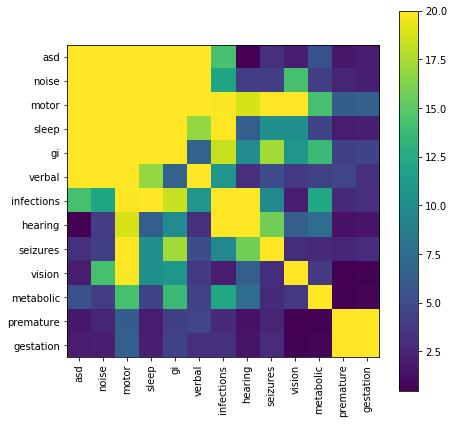

In [104]:
center = -np.log10(0.05/(13*13/2))

plt.figure(figsize=(7, 7))
plt.imshow(np.clip(-np.log10(X), 0, 20))
plt.colorbar()
plt.xticks(range(len(attrs)), attrs, rotation=90)
plt.yticks(range(len(attrs)), attrs)
plt.show()

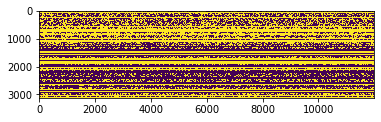

In [140]:
# below, we'll estimate pvalues by permuting ASD status within families
# asd=1, nt=0

num_trials = 12000
permuted_asd_status = np.zeros((len(children), num_trials))
child_to_index = dict([(x.id, i) for i, x in enumerate(children)])

for fam, fam_children in fam_to_children.items():
    asd_status = [1 if child.asd=='yes' else 0 for child in fam_children]
    permuted_asd_status[[child_to_index[child.id] for child in fam_children], :] = np.array([random.sample(asd_status, k=len(asd_status)) for _ in range(num_trials)]).T

plt.imshow(permuted_asd_status)


In [146]:
# takes time to run due to permutations
permutation_pvalues = np.ones((len(attrs)-1))
chi2_pvalues = np.ones((len(attrs)-1))

# categorical
for i, attr_i in enumerate(cat_attrs[1:]):
    print(attr_i, end=' ')
    options_i = [y for y in set([getattr(x, attr_i) for x in children]) if y!='']
    
    options_j = ['yes', 'no']
            
    c = np.zeros((len(options_i), len(options_j)))
    for k, opt_i in enumerate(options_i):
        c[k, 0] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, 'asd')=='yes'])
        c[k, 1] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, 'asd')=='no'])
    
    # estimate pvalues by permuting asd status within families
    s, p = stats.chi2_contingency(c)[:2]
    chi2_pvalues[i] = p
    num_over = 0
    for trial in range(num_trials):
        for k, opt_i in enumerate(options_i):
            c[k, 0] = len([x for j, x in enumerate(children) if getattr(x, attr_i)==opt_i and permuted_asd_status[j, trial]==1])
            c[k, 1] = len([x for j, x in enumerate(children) if getattr(x, attr_i)==opt_i and permuted_asd_status[j, trial]==0])
        num_over += int(stats.chi2_contingency(c)[0]>=s)
    permutation_pvalues[i] = num_over/num_trials


noise motor sleep gi premature hearing vision metabolic infections seizures 

In [152]:
# discrete
for i, attr_i in enumerate(disc_attrs):
    samples = [[getattr(x, attr_i) for x in children if getattr(x, 'asd')=='yes'],
              [getattr(x, attr_i) for x in children if getattr(x, 'asd')=='no']] 
        
    s, p = stats.kruskal(*samples)[:2]
    chi2_pvalues[i+len(cat_attrs)-1] = p
    num_over = 0
    for trial in range(num_trials):
        perm_samples = [[getattr(x, attr_i) for j, x in enumerate(children) if permuted_asd_status[j, trial]==1],
                        [getattr(x, attr_i) for j, x in enumerate(children) if permuted_asd_status[j, trial]==0]] 
        num_over += int(stats.kruskal(*perm_samples)[0]>=s)
    permutation_pvalues[i+len(cat_attrs)-1] = num_over/num_trials
        

In [153]:
print(permutation_pvalues)
print(chi2_pvalues)

[0.         0.         0.         0.         0.018      0.13475
 0.42883333 0.01033333 0.         0.         0.00375    0.        ]
[2.26818544e-65 2.33881228e-57 1.01258151e-31 4.66081699e-28
 1.68125871e-02 3.05040018e-01 8.94155768e-03 4.28036159e-06
 4.50191758e-15 8.86336253e-04 1.19569960e-02 2.74440732e-99]


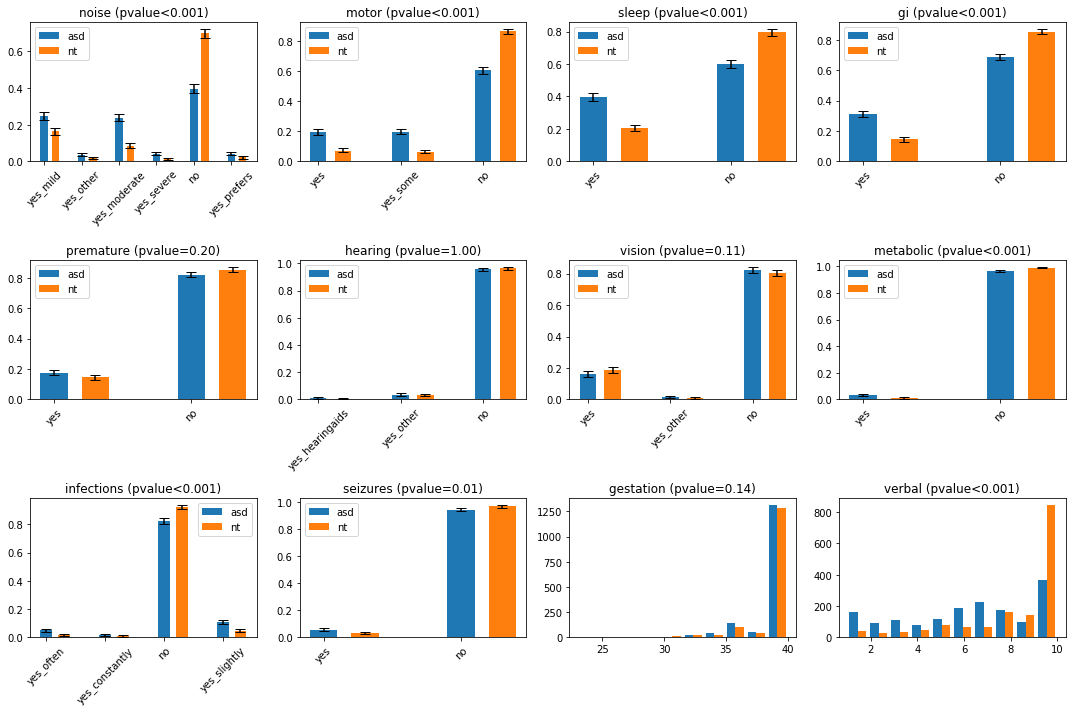

In [155]:
plt.figure(figsize=(15, 10))

def plotbar(r, total, offset=0, label=None):
    p = r/total
    lb, ub = sm.stats.proportion_confint(r, total, alpha=0.05, method='agresti_coull')
    plt.bar(np.arange(len(r))+offset, p, width=0.2, label=label)
    plt.errorbar(np.arange(len(r))+offset, p, 
                 yerr=[p-lb, ub-p], 
                 color='black', linestyle='', capsize=5)


# categorical
for i, attr_i in enumerate(cat_attrs[1:]):
    options_i = [y for y in set([getattr(x, attr_i) for x in children]) if y!='']
    
    options_j = ['yes', 'no']
            
    c = np.zeros((len(options_i), len(options_j)))
    for k, opt_i in enumerate(options_i):
        c[k, 0] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, 'asd')=='yes'])
        c[k, 1] = len([x for x in children if getattr(x, attr_i)==opt_i and getattr(x, 'asd')=='no'])
    
    plt.subplot(3, 4, i+1)
    plotbar(c[:, 0], np.sum(c[:, 0]), label='asd')
    plotbar(c[:, 1], np.sum(c[:, 1]), offset=0.3, label='nt')
    
    #plt.bar(np.arange(len(options_i)), c[:, 0], width=0.2, label=options_j[0])
    #plt.bar(np.arange(len(options_i))+0.3, c[:, 1], width=0.2, label=options_j[1])
    plt.title('%s (pvalue%s)' % (attr_i, '<0.001' if 12*chi2_pvalues[i]<0.001 else ('=%0.2f' % np.clip(12*chi2_pvalues[i], 0, 1))))
    plt.xticks(np.arange(len(options_i)), options_i, rotation=45)
    plt.legend()
    

# discrete
for i, attr_i in enumerate(disc_attrs):
    samples = [[getattr(x, attr_i) for x in children if getattr(x, 'asd')=='yes'],
               [getattr(x, attr_i) for x in children if getattr(x, 'asd')=='no']]
        
    plt.subplot(3, 4, i+len(cat_attrs))
    plt.hist(samples)
    plt.title('%s (pvalue%s)' % (attr_i, '<0.001' if 12*chi2_pvalues[i+len(cat_attrs)-1]<0.001 else ('=%0.2f' % np.clip(12*chi2_pvalues[i+len(cat_attrs)-1], 0, 1))))
    
plt.tight_layout()
plt.show()